In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from multiprocessing import Pool
from lampe.data import JointLoader
from itertools import islice
from tqdm import tqdm
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot

#import sys
#sys.path.insert(0, "../scr/cryo_sbi/inference/")
#sys.path.insert(0, "../scr/cryo_sbi/inference/models")
#sys.path.insert(0, "../scr/cryo_sbi/wpa_simulator/")

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_name = '23_03_17_results'      # File name 
data_dir = "../experiments/benchmark_hsp90/results/raw_data/"
plot_dir = "../experiments/benchmark_hsp90/results/plots/"
config_dir = "../experiments/benchmark_hsp90/"
num_samples_stats = 5000           # Number of simulations for computing posterior stats
num_samples_SBC = 2000             # Number of simulations for SBC
num_posterior_samples_SBC = 4096    # Number of posterior samples for each SBC simulation
num_samples_posterior = 5000       # Number of samples to draw from posterior
batch_size_sampling = 100           # Batch size for sampling posterior
num_workers = 24                    # Number of CPU cores
device = 'cuda'                     # Device for computations
save_figures = False

In [38]:
def posterior_std_mean(image_params, estimator):
    
    num_samples_posterior = 50000
    batch_size_sampling = 100
    num_samples_stats = 10000

    cryosbi = CryoEmSimulator(image_params)
    indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((num_samples_stats,))
    images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

    theta_samples = []
    with torch.no_grad():
        for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
            samples = estimator.sample(
                batched_images.cuda(non_blocking=True),
                shape=(num_samples_posterior,)
            ).cpu()
            theta_samples.append(
                samples.reshape(-1, batch_size_sampling)
            )
        samples = torch.cat(theta_samples, dim=1)

    mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
    posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
    confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

    return mean_distance, confidence_widths

In [3]:
train_config = json.load(open(config_dir + "resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(config_dir + "posterior_hsp90_ex.estimator"))
estimator.cuda()
estimator.eval();

In [5]:
for snr in np.logspace(np.log10(0.5), -2, 5):
    for defoc in np.linspace(0.5, 2, 4):
        means_confidence_width = posterior_std_mean(f'../experiments/benchmark_hsp90/image_params_snr={round(snr, 2)}_defocus={defoc}.json', estimator)
        torch.save(means_confidence_width, f'stats_snr={round(snr, 2)}_defocus={defoc}.pt')

../protein_models/hsp90_models.npy


/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy


Text(0, 0.5, 'Defocus')

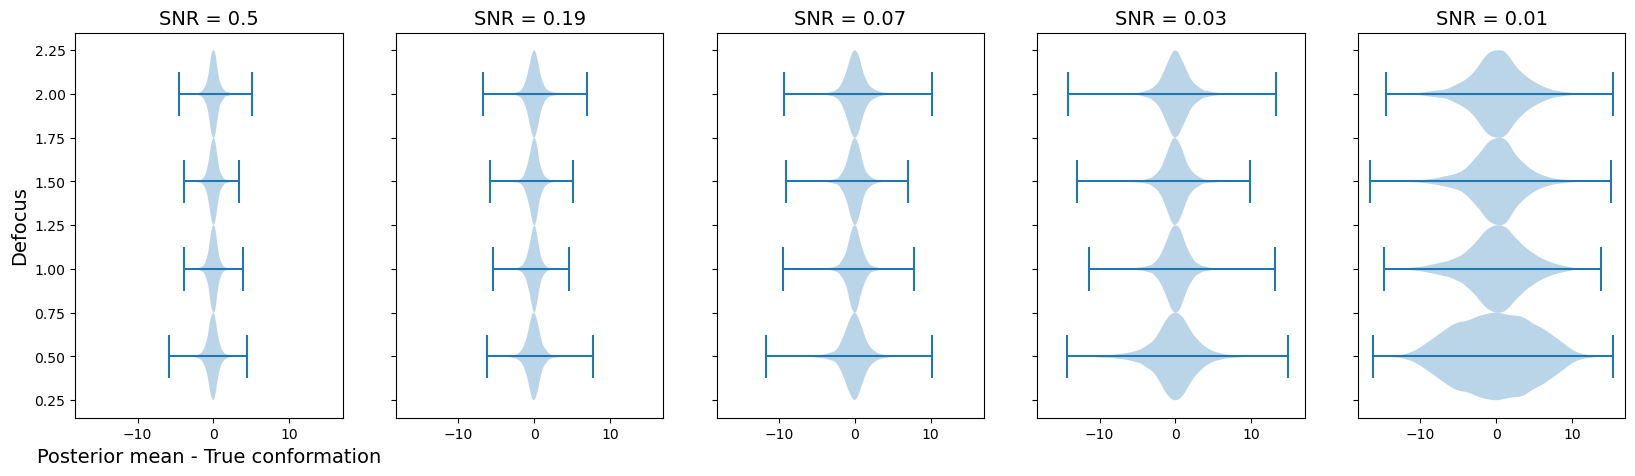

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True, sharey=True)
for idx, snr in enumerate(np.logspace(np.log10(0.5), -2, 5)):
    data = []
    for defoc in np.linspace(0.5, 2, 4):
        mean_diff, confidence = torch.load(f'stats_snr={round(snr, 2)}_defocus={defoc}.pt')
        data.append(mean_diff)
    axes[idx].violinplot(data, positions=np.linspace(0.5, 2, 4), vert=False)
    axes[idx].set_title(f'SNR = {round(snr, 2)}', fontsize=14)
#axes[0].set_xlabel(r'$3\sigma$-confidence width', fontsize=14)
axes[0].set_xlabel(r'Posterior mean - True conformation', fontsize=14)
axes[0].set_ylabel('Defocus', fontsize=14)
#fig.savefig('../experiments/benchmark_hsp90/results/plots/SNR_DEFOCUS_VIOLIN_mean.pdf', dpi=500)

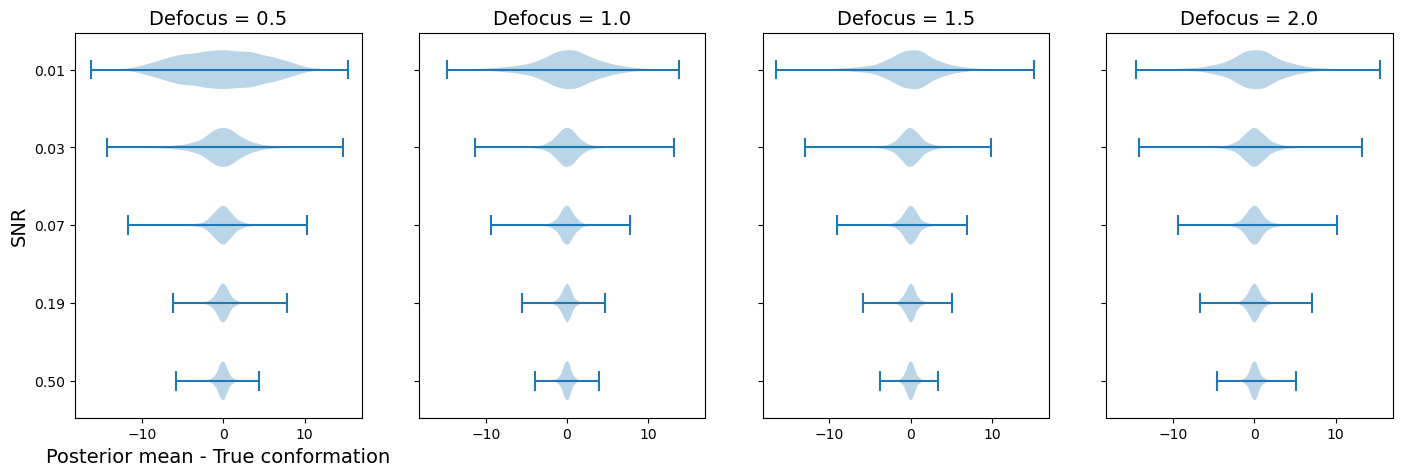

In [31]:
labels = [f'{snr:.2f}' for snr in np.logspace(np.log10(0.5), -2, 5)]
fig, axes = plt.subplots(1, 4, figsize=(17, 5), sharex=True, sharey=True)
for idx, defoc in enumerate(np.linspace(0.5, 2, 4)):
    data = []
    for snr in np.logspace(np.log10(0.5), -2, 5):
        mean_diff, confidence = torch.load(f'stats_snr={round(snr, 2)}_defocus={defoc}.pt')
        data.append(mean_diff)
    axes[idx].violinplot(data, vert=False)
    if defoc == 0.5:
        axes[idx].set_yticks([1, 2, 3, 4, 5])
        axes[idx].set_yticklabels(labels)
    axes[idx].set_title(f'Defocus = {defoc}', fontsize=14)
#axes[0].set_xlabel(r'$3\sigma$-confidence width', fontsize=14)
axes[0].set_xlabel(r'Posterior mean - True conformation', fontsize=14)
axes[0].set_ylabel('SNR', fontsize=14)
#fig.savefig('../experiments/benchmark_hsp90/results/plots/DEFOCUS_SNR_VIOLIN_mean.pdf', dpi=500)

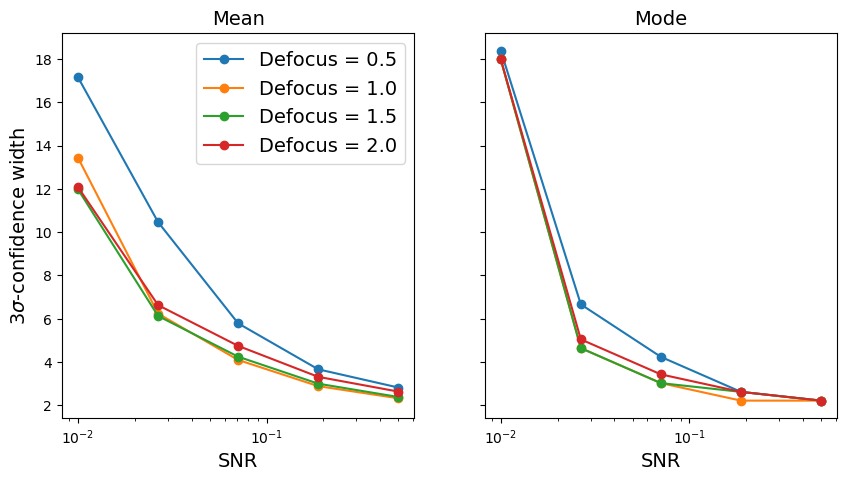

In [168]:



labels = [f'{snr:.2f}' for snr in np.logspace(np.log10(0.5), -2, 5)]
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for idx, defoc in enumerate(np.linspace(0.5, 2, 4)):
    x_data = []
    y_data_mode = []
    y_data_mean = []
    for snr in np.logspace(np.log10(0.5), -2, 5):
        mean_diff, confidence = torch.load(f'stats_snr={round(snr, 2)}_defocus={defoc}.pt')
        counts, bins = np.histogram(confidence, bins=np.linspace(-20, 20, 100))
        bins_width = bins[1] - bins[0]
        mode = bins[np.where(max(counts) == counts)[0]] + bins_width
        y_data_mode.append(mode)
        y_data_mean.append(np.mean(confidence))
        x_data.append(snr)
    axes[0].plot(x_data, y_data_mean, label=f'Defocus = {defoc}', marker='o')
    axes[1].plot(x_data, y_data_mode, label=f'Defocus = {defoc}', marker='o')
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_ylabel(r'$3\sigma$-confidence width', fontsize=14)
axes[0].set_xlabel('SNR', fontsize=14)
axes[1].set_xlabel('SNR', fontsize=14)
axes[0].set_title('Mean', fontsize=14)
axes[1].set_title('Mode', fontsize=14)
axes[0].legend(fontsize=14)
fig.savefig('../experiments/benchmark_hsp90/results/plots/mean_mode_confidence.pdf', dpi=500)

In [39]:
for i in range(0, 200, 20):

    file_name = f'posterior_hsp90.estimator_epoch={i}'
    train_config = json.load(open(config_dir + "resnet18_encoder.json"))
    estimator = build_models.build_npe_flow_model(train_config)
    estimator.load_state_dict(torch.load(config_dir + file_name))
    estimator.cuda()
    estimator.eval()

    means_confidence_width = posterior_std_mean(f'../experiments/benchmark_hsp90/image_params_snr={0.07}_defocus={1.5}.json', estimator)
    torch.save(means_confidence_width, f'stats_round={i}.pt')

file_name = f'posterior_hsp90.estimator'
train_config = json.load(open(config_dir + "resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(config_dir + file_name))
estimator.cuda()
estimator.eval()

means_confidence_width = posterior_std_mean(f'../experiments/benchmark_hsp90/image_params_snr={0.07}_defocus={1.5}.json', estimator)
torch.save(means_confidence_width, f'stats_round=200.pt')

../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy
../protein_models/hsp90_models.npy


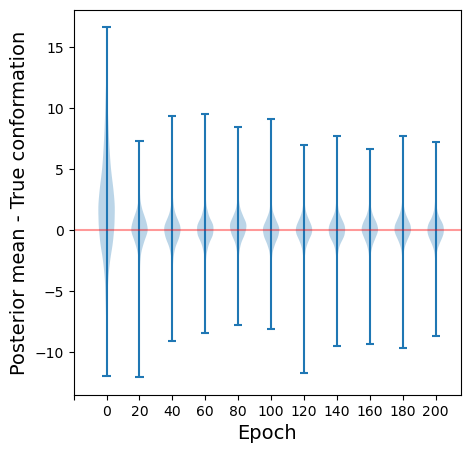

In [36]:
data = []
for i in range(0, 201, 20):
    file_name = f'stats_round={i}.pt'
    mean_diff, confidence = torch.load(file_name)
    data.append(mean_diff)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.violinplot(data)
axes.set_xticks(range(0, 12, 1))
labels = list(range(0, 201, 20))
labels.insert(0, '')
axes.set_xticklabels(labels)
axes.set_xlabel('Epoch', fontsize=14)
#axes.set_ylabel(r'$3\sigma$-confidence width', fontsize=14)
axes.set_ylabel(r'Posterior mean - True conformation', fontsize=14)
#axes.axhline(0, xmin=0, xmax=12, color='red', alpha=0.4)
#fig.savefig('Epochs_mean.pdf', dpi=400)

In [17]:
cryosbi = CryoEmSimulator("../experiments/benchmark_hsp90/image_params_training.json")
for i in range(0, 201, 20):

    file_name = f'posterior_hsp90.estimator_epoch={i}'
    if i == 200:
        file_name = f'posterior_hsp90.estimator'

    train_config = json.load(open(config_dir + "resnet18_encoder.json"))
    estimator = build_models.build_npe_flow_model(train_config)
    estimator.load_state_dict(torch.load(config_dir + file_name))
    estimator.cuda()
    estimator.eval()

    loader = JointLoader(
        priors.get_uniform_prior_1d(cryosbi.max_index),
        cryosbi.simulator,
        vectorized=False,
        batch_size=1, 
        num_workers=num_workers,
        prefetch_factor=1
    )

    levels, coverages = expected_coverage_mc(
        estimator.flow,
        ((estimator.standardize(theta.cuda()), x.cuda()) for theta, x in islice(loader, 20000)),
        n = num_posterior_samples_SBC
    )

    torch.save([levels, coverages], f'SBC_round={i}.pt')

../protein_models/hsp90_models.npy


/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  

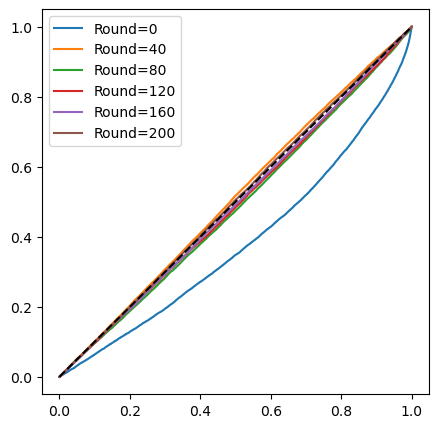

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
levels , coverages = [], []
for i in range(0, 201, 40):
    file_name = f'SBC_round={i}.pt'
    level, coverage = torch.load(file_name)
    axes.plot(level, coverage, label=f'Round={i}')
    #print(level)
    #levels.append(level)
    #coverages.append(coverage)
axes.plot([0,1], [0, 1], linestyle='--', color='black')
axes.legend()
fig.savefig('SBC_rounds.pdf', dpi=300)

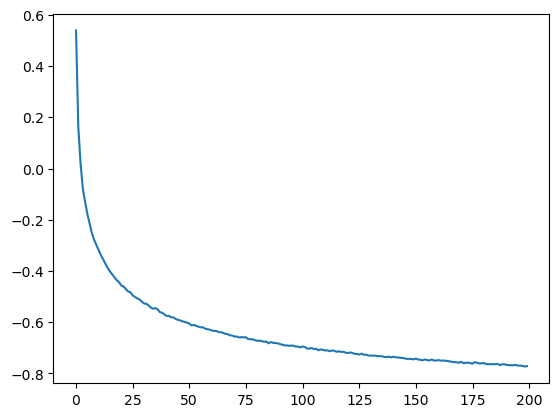

In [9]:
plt.plot(torch.load('../experiments/benchmark_hsp90/posterior_hsp90.loss'))

## Load cryo-em simulator and posterior with correct config

In [85]:
cryosbi = CryoEmSimulator("../experiments/benchmark_hsp90/image_params_training.json")

../protein_models/hsp90_models.npy


In [14]:
train_config = json.load(open(config_dir + "resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(config_dir + "posterior_hsp90_ex.estimator"))
estimator.cuda()
estimator.eval();

## Testing posterior on single images

In [20]:
indices = torch.tensor(np.arange(0, cryosbi.max_index + 1, 1), dtype=float)
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [21]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(
            samples
        )
    samples = torch.cat(theta_samples, dim=1)

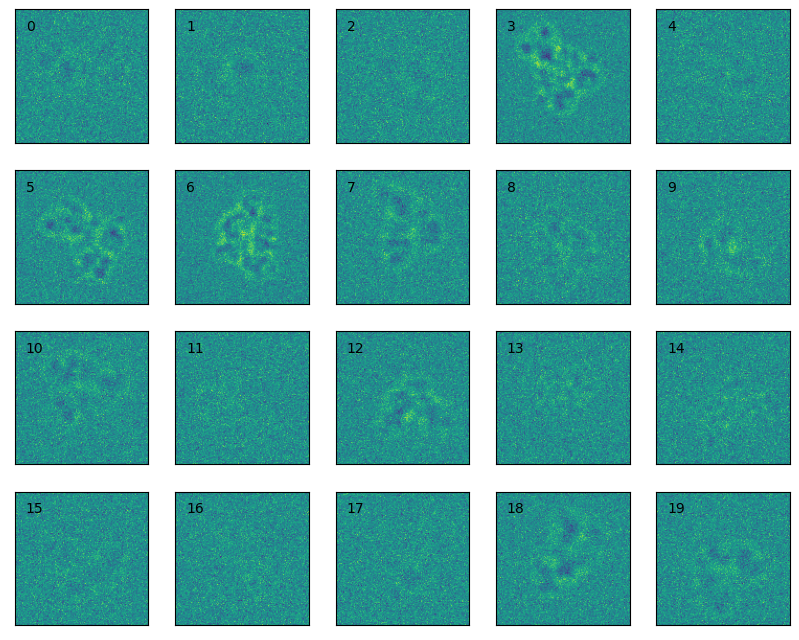

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx], vmax=5, vmin=-5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))
#plt.savefig('save_example_particles_old_settings.pdf', dpi=400)

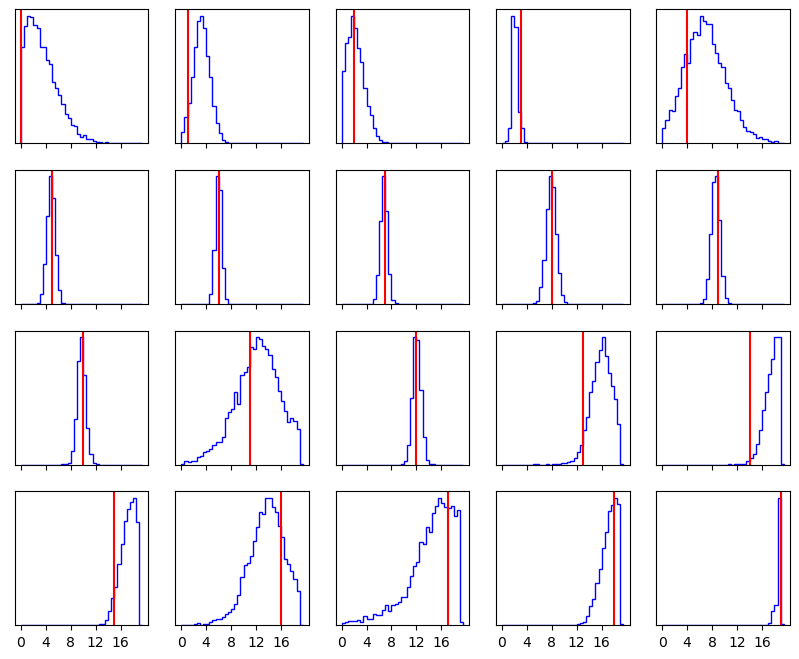

In [23]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(samples[:, idx].numpy(), bins=np.arange(0, 20, 0.5), histtype="step", color="blue", label="all")
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 20, 4))
    ax.axvline(indices[idx], color='red')
#plt.savefig('save_example_posterior_old_settings.pdf', dpi=400)

## Generate images from prior and evaluate posterior for statistical analysis

In [25]:
indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((5000,))
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [26]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(
            samples.reshape(-1, batch_size_sampling)
        )
    samples = torch.cat(theta_samples, dim=1)

In [27]:
mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

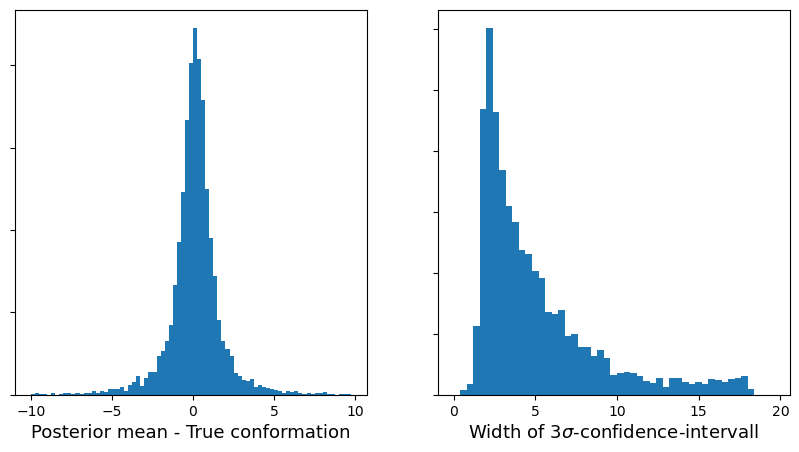

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
_ = ax1.hist(mean_distance, bins=np.arange(-10, 10, 0.25), density=True)
_ = ax2.hist(confidence_widths, bins=np.arange(0, 20, 0.4), density=True)
ax1.set_xlabel('Posterior mean - True conformation', fontsize=13)
ax2.set_xlabel(r'Width of 3$\sigma$-confidence-intervall', fontsize=13)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
fig.savefig('posterior_accuracy_precision.pdf', dpi=400)

## Compute posterior calibration

10000pair [02:18, 72.46pair/s]


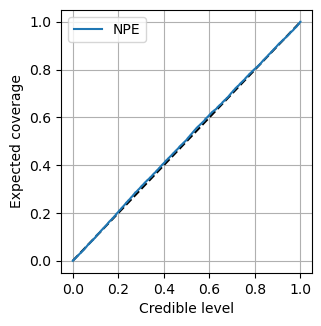

In [30]:

loader = JointLoader(
    priors.get_uniform_prior_1d(cryosbi.max_index),
    cryosbi.simulator,
    vectorized=False,
    batch_size=1, 
    num_workers=num_workers,
    prefetch_factor=1
)

levels, coverages = expected_coverage_mc(
    estimator.flow,
    ((estimator.standardize(theta.cuda()), x.cuda()) for theta, x in islice(loader, 10000)),
    n = num_posterior_samples_SBC
)

fig = coverage_plot(levels, coverages, legend='NPE')

#fig.savefig(f'posterior_hsp90_SBC.pdf', dpi=400)

if save_figures:
    fig.savefig(
        f'{plot_dir}{file_name}_SBC.pdf',
        dpi=400
    )

## Generate images from index 10 with known quaternion

In [ ]:
quats = torch.from_numpy(np.load('quaternion_list.npy'))[:5000]
num_simulations = len(quats)
indices = 10 * torch.ones(num_simulations).reshape(-1, 1)
parameters = torch.cat((indices, quats), dim=1)
images = torch.stack([cryosbi._simulator_with_quat(param) for param in parameters], dim=0)

In [ ]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(
            samples.reshape(-1, batch_size_sampling)
        )
samples = torch.cat(theta_samples, dim=1)

In [ ]:
mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

unit_vecotr = np.array([0, 0, 1])
points = []
for i in range(len(quats)):
    rot_mat = Rotation.from_quat(quats[i]).as_matrix()
    coord = np.matmul(rot_mat, unit_vecotr)
    points.append(coord)
points = np.array(points)

xx = points[:, 0]
yy = points[:, 1]
zz = points[:, 2]

#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_surface(
#    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

im = ax.scatter(xx, yy, zz, s=confidence_widths, c=confidence_widths)

ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.azim = -40
ax.elev = 30
ax.dist = 10

fig.colorbar(im)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("auto")
plt.tight_layout()
plt.show()